# Laboratorium: Rekurencyjne sieci neuronowe


## 2.1 Pobieranie danych

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


In [111]:
tf.keras.utils.get_file(
    "bike_sharing_dataset.zip",
    "https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip",
    cache_dir=".",
    extract=True
)


'.\\datasets\\bike_sharing_dataset_extracted'

## 2.2 Przygotowanie danych

In [112]:
df = pd.read_csv('datasets/bike_sharing_dataset_extracted/hour.csv')
df['datetime'] = pd.to_datetime(df['dteday'] + ' ' + df['hr'].astype(str).str.zfill(2), format = '%Y-%m-%d %H')
df.set_index('datetime', inplace=True)



In [113]:
print(df[:1])

            instant      dteday  season  yr  mnth  hr  holiday  weekday  \
datetime                                                                  
2011-01-01        1  2011-01-01       1   0     1   0        0        6   

            workingday  weathersit  temp   atemp   hum  windspeed  casual  \
datetime                                                                    
2011-01-01           0           1  0.24  0.2879  0.81        0.0       3   

            registered  cnt  
datetime                     
2011-01-01          13   16  


In [114]:
print((df.index.min(), df.index.max()))


(Timestamp('2011-01-01 00:00:00'), Timestamp('2012-12-31 23:00:00'))


In [115]:
print('dataset rows count: ', len(df))
print('should be: ', (365 + 366) * 24)
print('missing: ', (365 + 366) * 24 - len(df), ' rows')


dataset rows count:  17379
should be:  17544
missing:  165  rows


Okazuje się, że w zbiorze brakuje rekordów dla okresów (godzin) podczas których nikt nie korzystał z
rowerów. Aby szeregi czasowe były regularne, trzeba je uzupełnić. Przy okazji pozbędziemy się
niepotrzebnych kolumn

In [116]:
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')

df_resampled = df.reindex(full_index)

# dla kolumn przechowujących zarejestrowane liczby wypożyczeń 
# (casual, registered, cnt), wypełnij brakujące wiersze zerami,
cols_to_fill_zero = ['casual', 'registered', 'cnt']
df_resampled[cols_to_fill_zero] = df_resampled[cols_to_fill_zero].fillna(0)

# dla kolumn przechowujących sensoryczne dane pogodowe 
# (temp, atemp, hum, windspeed), zastosuj interpolację
cols_to_interpolate = ['temp', 'atemp', 'hum', 'windspeed']
df_resampled[cols_to_interpolate] = df_resampled[cols_to_interpolate].interpolate(method='time')


# dla kolumn kategoryzowanych (holiday, weekday, workingday, weathersit),
#  wypełnij brakujące wartości z poprzedniego rekordu.
cols_to_fill_prev = ['holiday', 'weekday', 'workingday', 'weathersit']
# forward fill - ffill - Fill NA/NaN values by propagating the last valid observation to next valid.
df_resampled[cols_to_fill_prev] = df_resampled[cols_to_fill_prev].fillna(method='ffill')

df = df_resampled


C:\Users\chame\AppData\Local\Temp\ipykernel_5860\1761014142.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_resampled[cols_to_fill_prev] = df_resampled[cols_to_fill_prev].fillna(method='ffill')


### Sprawdzenie czy dataframe ma odpowiednia strukture

In [117]:
print(df.notna().sum())


instant       17379
dteday        17379
season        17379
yr            17379
mnth          17379
hr            17379
holiday       17544
weekday       17544
workingday    17544
weathersit    17544
temp          17544
atemp         17544
hum           17544
windspeed     17544
casual        17544
registered    17544
cnt           17544
dtype: int64


In [118]:
print(df[['casual', 'registered', 'cnt', 'weathersit']].describe())


             casual    registered           cnt    weathersit
count  17544.000000  17544.000000  17544.000000  17544.000000
mean      35.340686    152.340515    187.681202      1.434223
std       49.193293    151.373409    181.456478      0.648339
min        0.000000      0.000000      0.000000      1.000000
25%        4.000000     32.000000     38.000000      1.000000
50%       16.000000    114.000000    140.000000      1.000000
75%       48.000000    219.000000    279.000000      2.000000
max      367.000000    886.000000    977.000000      4.000000


In [119]:
df.casual = df.casual / 1e3
df.registered = df.registered / 1e3
df.cnt = df.cnt / 1e3
df.weathersit = df.weathersit / 4

print(df[['casual', 'registered', 'cnt', 'weathersit']].describe())

             casual    registered           cnt    weathersit
count  17544.000000  17544.000000  17544.000000  17544.000000
mean       0.035341      0.152341      0.187681      0.358556
std        0.049193      0.151373      0.181456      0.162085
min        0.000000      0.000000      0.000000      0.250000
25%        0.004000      0.032000      0.038000      0.250000
50%        0.016000      0.114000      0.140000      0.250000
75%        0.048000      0.219000      0.279000      0.500000
max        0.367000      0.886000      0.977000      1.000000


<Axes: >

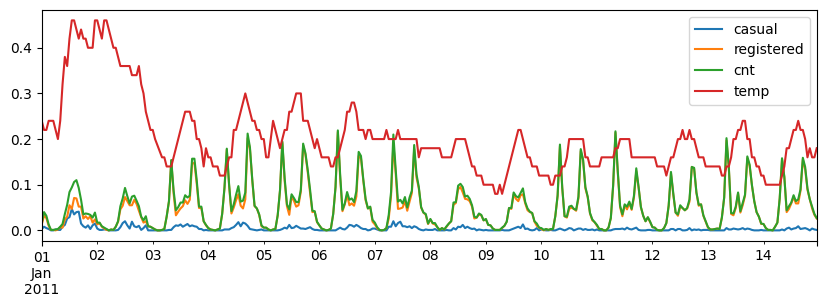

In [120]:
df_2weeks = df[:24*7*2]
df_2weeks[['casual', 'registered', 'cnt', 'temp']].plot(figsize=(10,3))


In [121]:
print(df.dtypes)

instant       float64
dteday         object
season        float64
yr            float64
mnth          float64
hr            float64
holiday       float64
weekday       float64
workingday    float64
weathersit    float64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual        float64
registered    float64
cnt           float64
dtype: object


<Axes: >

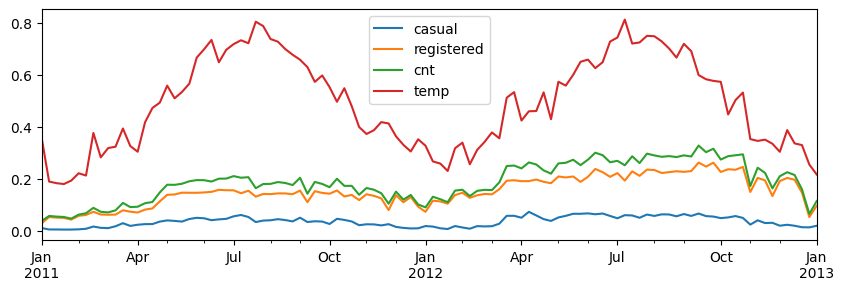

In [122]:
df['dteday'] = pd.to_datetime(df['dteday'])
df_daily = df.resample('W').mean()
df_daily[['casual', 'registered', 'cnt', 'temp']].plot(figsize=(10, 3))



## 2.3 Wskaźniki bazowe - uzywajac sredniego bledu bezwzglednego 

In [123]:
# dla doby:
df['cnt_pred_daily'] = df['cnt'].shift(24) # 24 godziny wczesniej
mae_daily = np.abs(df['cnt'].dropna() * 1000 - df['cnt_pred_daily'].dropna() * 1000).mean()
print(mae_daily)

# dla tygodnia
df['cnt_pred_weekly'] = df['cnt'].shift(24*7) # 7 dni wczesniej
mae_weekly = np.abs(df['cnt'].dropna() * 1000 - df['cnt_pred_weekly'].dropna() * 1000).mean()
print(mae_weekly)

mae_baseline = (mae_daily, mae_weekly)

import pickle

with open('mae_baseline.pkl', 'wb') as file:
    pickle.dump(mae_baseline, file)


63.79497716894977
52.42506906077348


## 2.4 Predykcja przy pomocy sieci gęstej

proporcja: 18 miesiecy treningowy, 6 miesiecy walidacyjny

In [124]:
cnt_train = df['cnt']['2011-01-01 00:00' : '2012-06-30 23:00']
cnt_valid = df['cnt']['2012-07-01 00:00':]

In [125]:
seq_len = 1 * 24

# timeseries_dataset_from_array() - tworzy okna dancyh wejsciowych z etykietami
# seq_len  - definiuje dlugosc sekwencji wejsciowej (wielkosc okna) na 24 rekordy czyli jedna doba

# chodzi o to ze na podstawie 24 godizn model ma przewidziec kolejna wartosc jaka bedzie w 25 godzinie jakby

train_ds = tf.keras.utils.timeseries_dataset_from_array(
    cnt_train.to_numpy(),               # dane wejsciowe jako tablica numpy
    targets=cnt_train[seq_len:],        # wartosci docelowe ktore model ma przewidziec
    sequence_length=seq_len,            # kazda probka bedzie miala dlugosc 24
    batch_size=32,                      # dane beda pogrupowane po 32 paczki
    shuffle=True,                       # przetasowanie
    seed=42                             
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    cnt_valid.to_numpy(),
    targets=cnt_valid[seq_len:],
    sequence_length=seq_len,
    batch_size=32
)



In [126]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(seq_len,)),
    tf.keras.layers.Dense(1)
])

In [127]:
optimizer = tf.keras.optimizers.SGD(momentum=0.9, learning_rate=0.1)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])

In [128]:
history = model.fit(train_ds, epochs=20, validation_data=valid_ds)

Epoch 1/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0058 - mae: 0.0709 - val_loss: 0.0038 - val_mae: 0.0590
Epoch 2/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0020 - mae: 0.0436 - val_loss: 0.0036 - val_mae: 0.0577
Epoch 3/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0019 - mae: 0.0417 - val_loss: 0.0036 - val_mae: 0.0565
Epoch 4/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0019 - mae: 0.0413 - val_loss: 0.0038 - val_mae: 0.0627
Epoch 5/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0019 - mae: 0.0419 - val_loss: 0.0038 - val_mae: 0.0620
Epoch 6/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0019 - mae: 0.0415 - val_loss: 0.0034 - val_mae: 0.0563
Epoch 7/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0018 - mae: 0.0406 - val_loss: 0.0035 - val_mae: 0.0565
Epoch 8/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0018 - mae: 0.0402 - val_loss: 0.0036 - val_mae: 0.0580
Epoch 9/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - lo

In [129]:
validation_mae = history.history['val_mae'][-1]
scaled_mae = validation_mae * 1000
print(scaled_mae)

# 56.22904747724533 jest lepsze niz bazowy 65.0561797752809


56.70224875211716


In [130]:
model.save('model_linear.keras')

mae_linear = (scaled_mae)
with open(' mae_linear.pkl', 'wb') as file:
    pickle.dump(mae_linear, file)



## 2.5 Prosta sieć rekurencyjna

### Utwórz prostą sieć rekurencyjną, zawierającą jedną warstwę z jednym neuronem

In [131]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=[None,1]),
    tf.keras.layers.LSTM(1)
])



In [132]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,
              metrics=['mae'])


In [133]:
history = model.fit(train_ds, epochs=20, validation_data=valid_ds)

Epoch 1/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0108 - mae: 0.1133 - val_loss: 0.0190 - val_mae: 0.1530
Epoch 2/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0095 - mae: 0.1062 - val_loss: 0.0180 - val_mae: 0.1501
Epoch 3/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0092 - mae: 0.1046 - val_loss: 0.0173 - val_mae: 0.1461
Epoch 4/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0089 - mae: 0.1027 - val_loss: 0.0165 - val_mae: 0.1439
Epoch 5/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0085 - mae: 0.1008 - val_loss: 0.0159 - val_mae: 0.1415
Epoch 6/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0082 - mae: 0.0992 - val_loss: 0.0152 - val_mae: 0.1373
Epoch 7/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0079 - mae: 0.0973 - val_loss: 0.0146 - val_mae: 0.1360
Epoch 8/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0077 - mae: 0.0961 - val_loss: 0.0140 - val_mae: 0.1335
Epoch 9/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/s

In [ ]:
validation_mae = history.history['val_mae'][-1]
scaled_mae = validation_mae * 1000
print(scaled_mae)
# 106.5203994512558 wiec slabo



106.5203994512558


In [135]:
mae_rnn1 = (scaled_mae)

with open('mae_rnn1.pkl', 'wb') as file:
    pickle.dump(mae_rnn1, file)

In [136]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=[None, 1]),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])



In [137]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,
              metrics=['mae'])


In [138]:
history = model.fit(train_ds, epochs=20, validation_data=valid_ds)


Epoch 1/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.0065 - mae: 0.0820 - val_loss: 0.0054 - val_mae: 0.0661
Epoch 2/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0026 - mae: 0.0474 - val_loss: 0.0045 - val_mae: 0.0606
Epoch 3/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0023 - mae: 0.0437 - val_loss: 0.0045 - val_mae: 0.0689
Epoch 4/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0022 - mae: 0.0437 - val_loss: 0.0040 - val_mae: 0.0599
Epoch 5/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0022 - mae: 0.0437 - val_loss: 0.0039 - val_mae: 0.0598
Epoch 6/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0021 - mae: 0.0423 - val_loss: 0.0040 - val_mae: 0.0576
Epoch 7/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0021 - mae: 0.0419 - val_loss: 0.0036 - val_mae: 0.0571
Epoch 8/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0019 - mae: 0.0405 - val_loss: 0.0033 - val_mae: 0.0532
Epoch 9/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 10s 23m

In [ ]:
validation_mae = history.history['val_mae'][-1]
scaled_mae = validation_mae * 1000
print(scaled_mae)
#  44.81298476457596 wiec znacznie lepiej


44.81298476457596


In [140]:
model.save('model_rnn32.keras')

mae_rnn32 = (scaled_mae)

with open('mae_rnn32.pkl', 'wb') as file:
    pickle.dump(mae_rnn32, file)

## 2.6 Głęboka RNN


In [141]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[None, 1]),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(1)
])


In [142]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,
              metrics=['mae'])



In [143]:
history = model.fit(train_ds, epochs=20, validation_data=valid_ds)


Epoch 1/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - loss: 0.0114 - mae: 0.1136 - val_loss: 0.0132 - val_mae: 0.1129
Epoch 2/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - loss: 0.0061 - mae: 0.0801 - val_loss: 0.0122 - val_mae: 0.1072
Epoch 3/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - loss: 0.0055 - mae: 0.0759 - val_loss: 0.0093 - val_mae: 0.0962
Epoch 4/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - loss: 0.0050 - mae: 0.0718 - val_loss: 0.0079 - val_mae: 0.0889
Epoch 5/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - loss: 0.0044 - mae: 0.0657 - val_loss: 0.0072 - val_mae: 0.0803
Epoch 6/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - loss: 0.0040 - mae: 0.0611 - val_loss: 0.0068 - val_mae: 0.0769
Epoch 7/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - loss: 0.0034 - mae: 0.0550 - val_loss: 0.0058 - val_mae: 0.0685
Epoch 8/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - loss: 0.0024 - mae: 0.0462 - val_loss: 0.0036 - val_mae: 0.0603
Epoch 9/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
validation_mae = history.history['val_mae'][-1]
scaled_mae = validation_mae * 1000
print(scaled_mae)

# 36.5825854241848 wiec to jescze lepiej

36.5825854241848


In [145]:
model.save('model_rnn_deep.keras')

mae_rnn_deep = (scaled_mae)
with open('mae_rnn_deep.pkl', 'wb') as file:
    pickle.dump(mae_rnn_deep, file)

## 2.7 Model wielowymiarowy

In [157]:
feature_cols = ['cnt', 'weathersit', 'atemp', 'workingday']

X_train_mv_df = df[feature_cols]['2011-01-01 00:00':'2012-06-30 23:00']
X_valid_mv_df = df[feature_cols]['2012-07-01 00:00':]

y_train_mv_series = df['cnt']['2011-01-01 00:00':'2012-06-30 23:00']
y_valid_mv_series = df['cnt']['2012-07-01 00:00':]

seq_len = 1 * 24

# timeseries_dataset_from_array() - tworzy okna dancyh wejsciowych z etykietami
# seq_len  - definiuje dlugosc sekwencji wejsciowej (wielkosc okna) na 24 rekordy czyli jedna doba

# chodzi o to ze na podstawie 24 godizn model ma przewidziec kolejna wartosc jaka bedzie w 25 godzinie jakby

train_ds = tf.keras.utils.timeseries_dataset_from_array(
    X_train_mv_df.to_numpy(),               # dane wejsciowe jako tablica numpy
    targets=y_train_mv_series.to_numpy()[seq_len:],        # wartosci docelowe ktore model ma przewidziec
    sequence_length=seq_len,            # kazda probka bedzie miala dlugosc 24
    batch_size=32,                      # dane beda pogrupowane po 32 paczki
    shuffle=True,                       # przetasowanie
    seed=42                             
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    X_valid_mv_df.to_numpy(),
    targets=y_valid_mv_series.to_numpy()[seq_len:],
    sequence_length=seq_len,
    batch_size=32
)

In [158]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=[None, 4]),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])

In [159]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,
              metrics=['mae'])



In [160]:
history = model.fit(train_ds, epochs=20, validation_data=valid_ds)


Epoch 1/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0088 - mae: 0.0970 - val_loss: 0.0076 - val_mae: 0.0794
Epoch 2/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0031 - mae: 0.0542 - val_loss: 0.0046 - val_mae: 0.0627
Epoch 3/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0021 - mae: 0.0438 - val_loss: 0.0036 - val_mae: 0.0549
Epoch 4/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0018 - mae: 0.0407 - val_loss: 0.0043 - val_mae: 0.0633
Epoch 5/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0019 - mae: 0.0420 - val_loss: 0.0032 - val_mae: 0.0521
Epoch 6/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0016 - mae: 0.0381 - val_loss: 0.0031 - val_mae: 0.0504
Epoch 7/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0014 - mae: 0.0360 - val_loss: 0.0035 - val_mae: 0.0542
Epoch 8/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0014 - mae: 0.0357 - val_loss: 0.0032 - val_mae: 0.0524
Epoch 9/20
410/410 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/

In [161]:
validation_mae = history.history['val_mae'][-1]
scaled_mae = validation_mae * 1000
print(scaled_mae)



39.15490210056305


In [ ]:
model.save('model_rnn_mv.keras')

mae_rnn_mv = (scaled_mae)
with open('mae_rnn_mv.pkl', 'wb') as file:
    pickle.dump(mae_rnn_mv, file)